#### A coding introduction to Markov Decision Process

In [103]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [104]:
# This may work in a Jupyter Notebook/Google Colab environment
!pip install gymnasium


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [105]:
!pip install imageio imageio[pyav]


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [127]:
import gymnasium as gym
import numpy as np
from IPython import display
import matplotlib.pyplot as plt


import imageio
from IPython.display import HTML
import base64

import sys, os
sys.path.insert(0, os.getcwd())

from envs.maze import Maze

%matplotlib inline

In [107]:
# create the environment
env = Maze()

#### env.reset()

This method places the environemnt in initial state to and returns it so that the agent can observe

In [108]:
initial_state = env.reset()
print(f"the new episode will start in the state {initial_state} ")

the new episode will start in the state ((0, 0), {}) 


#### env.render()

This method generates an image that represents the current state of teh environment,in teh form of a np.ndarray

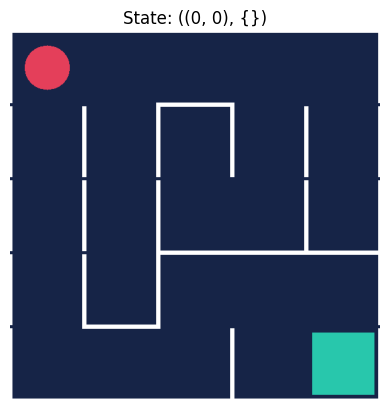

In [109]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {initial_state}")
plt.imshow(frame)

#### env.step()

This method applies the action selected by the agent in the environment, to modify it. In response, the environemmnt returns a tuple of five objects:
 - The next state
 - The reward obtained
 - (bool) if the task has been completed
 - any other relevant information in a python dictionary


In [110]:
action = 2
#next_state,reward,done,info = env.step(action)
next_state, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

print(f"After moving down 1 row,the agent is in state: {next_state}")
print(f"After moving down 1 row, we got a reward of: {reward}")
print(f"After moving down 1 row,the task is","" if done else "not","finished")

After moving down 1 row,the agent is in state: (1, 0)
After moving down 1 row, we got a reward of: -1.0
After moving down 1 row,the task is not finished


#### Render the new state

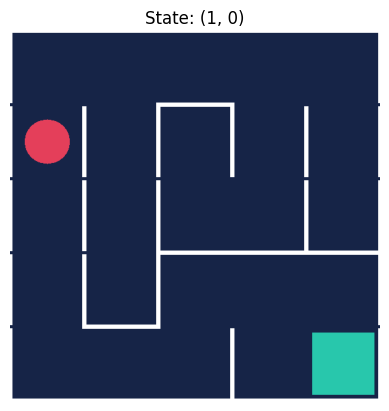

In [111]:
frame  = env.render(mode='rgb_array')
plt.axis('off')
plt.title(f"State: {next_state}")
plt.imshow(frame)

#### env.close()

It completes the task and close the environment, releasing associated resources

In [112]:
env.close()

## Maze environment: Find the exit.


In this section we are going to familiarize ourselves with the environment that we'll use in the lessons 2 (dynamic programming), 3 (Monte Carlo methods) and 4 (temporal difference methods). This environment is perfect for learning the basics of Reinforcement Learning because:

- It has few states (25)
- Transitions between states are deterministic ($p(s', r| s, a) = 1$)
- All rewards are the same (-1) until the episode concludes. Thus facilitating the study of the value and action-value functions

Through this environment, we are going to review the concepts seen in lesson 1 (The Markov decision process):

- States and state space
- Actions and action space
- Trajectories and episodes
- Rewards and returns
- Policy


The environment is a maze of 5x5 cells, in which the goal of the agent is to find the exit, located in the lower right corner, in the cell (4,4). In the image, the exit is colored in light green.

To reach the exit, the agent can take four different actions: move up, move down, move left and move right.

In [113]:
#Create the environment
env = Maze()

##### States and state space

The states consist of a tuple of two integers, both in the range [0, 4], representing the row and column in which the agent is currently located:
<br>
<br>

\begin{equation}
    s = (row, column) \;\\
    row, column \in \{0,1,2,3, 4\}
\end{equation}
<br>
<br>
The state space (set of all possible states in the task) has 25 elements (all possible combinations of rows and columns):


\begin{equation}
    Rows \times Columns \;\\
    S = \{(0, 0), (0, 1), (1, 0), ...\}
\end{equation}

Information about the state space is stored in the env.observation_space property. In this environment, it is of MultiDiscrete([5 5]) type, which means that it consists of two elements (rows and columns), each with 5 different values.

In [114]:
print(f"The initial state is : {env.reset()}")
print(f"The space state space if of type: {env.observation_space}")

The initial state is : ((0, 0), {})
The space state space if of type: MultiDiscrete([5 5])


##### Actions and action space

In this environment, there are four different actions and they are represented by integers:

\begin{equation}
a \in \{0, 1, 2, 3\}
\end{equation}

- 0 -> move up
- 1 -> move right
- 2 -> move down
- 3 -> move left

To execute an action, simply pass it as an argument to the env.step method. Information about the action space is stored in the env.action_space property which is of Discrete(4) class. This means that in this case it only consists of an element in the range [0,4), unlike the state space seen above.


In [115]:
print(f"An example of valid action: {env.action_space.sample()}")
print(f"The action state if of type: {env.action_space}")

An example of valid action: 0
The action state if of type: Discrete(4)


##### Trajectories and episodes

A trajectory is the sequence generated by moving from one state to another (both arbitrary)

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_N, S_N,
\end{equation}

Let's generate a trajectory of 3 moves in code:

In [116]:
env = Maze()
state = env.reset()
trajectory = []

for _ in range(3):
    action  = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    trajectory.append([state,action,reward,done,next_state])
    state = next_state
env.close()    
print(f"Look the firstt trajectory: {trajectory}")

Look the firstt trajectory: [[((0, 0), {}), np.int64(1), -1.0, False, (0, 1)], [(0, 1), np.int64(3), -1.0, False, (0, 0)], [(0, 0), np.int64(0), -1.0, False, (0, 0)]]


An episode is a trajectory that goes from the initial state of the process to the final one:

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_T, S_T,
\end{equation}
where T is the terminal state.

Let's generate a whole episode in code:

In [117]:
env  = Maze()
state = env.reset()
episode = []
done = False
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    episode.append([state,action,reward,done,next_state])
    state = next_state
    #if terminated:
    #    print("✅ Reached the goal!")
    #elif steps >= max_steps:
    #    print("⚠️ Episode truncated: max steps reached")
env.close()
print(f"You have generated the full epoisode: {episode}")

You have generated the full epoisode: [[((0, 0), {}), np.int64(0), -1.0, False, (0, 0)], [(0, 0), np.int64(2), -1.0, False, (1, 0)], [(1, 0), np.int64(1), -1.0, False, (1, 0)], [(1, 0), np.int64(1), -1.0, False, (1, 0)], [(1, 0), np.int64(2), -1.0, False, (2, 0)], [(2, 0), np.int64(3), -1.0, False, (2, 0)], [(2, 0), np.int64(3), -1.0, False, (2, 0)], [(2, 0), np.int64(1), -1.0, False, (2, 0)], [(2, 0), np.int64(2), -1.0, False, (3, 0)], [(3, 0), np.int64(2), -1.0, False, (4, 0)], [(4, 0), np.int64(1), -1.0, False, (4, 1)], [(4, 1), np.int64(0), -1.0, False, (4, 1)], [(4, 1), np.int64(2), -1.0, False, (4, 1)], [(4, 1), np.int64(2), -1.0, False, (4, 1)], [(4, 1), np.int64(2), -1.0, False, (4, 1)], [(4, 1), np.int64(1), -1.0, False, (4, 2)], [(4, 2), np.int64(0), -1.0, False, (3, 2)], [(3, 2), np.int64(1), -1.0, False, (3, 3)], [(3, 3), np.int64(3), -1.0, False, (3, 2)], [(3, 2), np.int64(0), -1.0, False, (3, 2)], [(3, 2), np.int64(1), -1.0, False, (3, 3)], [(3, 3), np.int64(0), -1.0, Fal

##### Rewards and returns

A reward is numerical feedback that the environment generates when the agent takes an action *a* in a state *s*:

\begin{equation}
    r = r(s, a)
\end{equation}

Let's generate a reward from the environment:

In [118]:
env = Maze()
state = env.reset()
action  = env.action_space.sample()
next_state,reward,terminated,truncated,info =  env.step(action)
print(f"We achieved a reward of {reward} by taking action {action} in state {state}")

We achieved a reward of -1.0 by taking action 1 in state ((0, 0), {})


The return associated with a moment in time *t* is the sum (discounted) of rewards that the agent obtains from that moment. We are going to calculate $G_0$, that is, the return to the beginning of the episode:

\begin{equation}
    G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + ... + \gamma^{T-1} R_T
\end{equation}



Let's assume that the discount factor $\gamma = 0.99$:


In [119]:
env = Maze()
state = env.reset()
done = False
gamma = 0.99
G_0 = 0
t = 0
while not done:
    action = env.action_space.sample()
    next_state,reward,terminated,truncated,info = env.step(action)
    done = terminated or truncated
    G_0 += gamma ** t * reward
    t += 1
env.close()

print(f"It took us {t} moves to find the exit (goal), and each reward r(s,a) = -1,so the return amount to {G_0}")

It took us 1244 moves to find the exit (goal), and each reward r(s,a) = -1,so the return amount to -99.99962830897078


##### Policy

A policy is a function $\pi(a|s) \in [0, 1]$ that gives the probability of an action given the current state. The function takes the state and action as inputs and returns a float in [0,1].

Since in practice we will need to compute the probabilities of all actions, we will represent the policy as a function that takes the state as an argument and returns the probabilities associated with each of the actions. Thus, if the probabilities are:

[0.5, 0.3, 0.1]

we will understand that the action with index 0 has a 50% probability of being chosen, the one with index 1 has 30% and the one with index 2 has 10%.

Let's code a policy function that chooses actions randomly:

In [120]:
def random_policy(state):
    return np.array([0.25] * 4)

In [121]:
#create and reset the environment
env = Maze()
state = env.reset()

Compute $p(a|s) \ \forall a \in \{0, 1, 2, 3\}$

In [122]:
action_probabilities = random_policy(state)

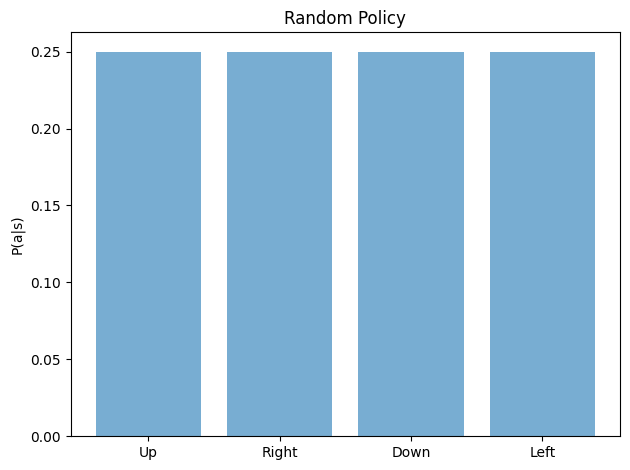

In [123]:
objects = ('Up','Right','Down','Left')
y_pos = np.arange(len(objects))

plt.bar(y_pos,action_probabilities,alpha=0.6)
plt.xticks(y_pos,objects)
plt.ylabel('P(a|s)')
plt.title('Random Policy')
plt.tight_layout()

plt.show()

In [128]:
def display_video(frames, fps=10, filename="maze_episode.mp4"):
    imageio.mimsave(
        filename,
        frames,
        fps=fps,
        codec="libx264"
    )

    with open(filename, "rb") as f:
        video_base64 = base64.b64encode(f.read()).decode()

    return HTML(f"""
    <video width="400" controls autoplay loop>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
    """)

##### Use the policy to play an episode 

 We save a screenshot of every state in the `frames` variable and then, we use the `display_video` function to turn those images into a video.


In [129]:
def test_agent(environment, policy):
    frames = []
    state, _ = env.reset()
    done = False

    frames.append(env.render(mode="rgb_array"))

    while not done:
        action_probs = policy(state)
        action = np.random.choice(4, p=action_probs)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        frames.append(env.render(mode="rgb_array"))
        state = next_state

    return display_video(frames)

#### NOTE: Uncomment the code below to run the test agent function to see the .mp4 video and look the agent behavior instead of images

In [131]:
#test_agent(env,random_policy)

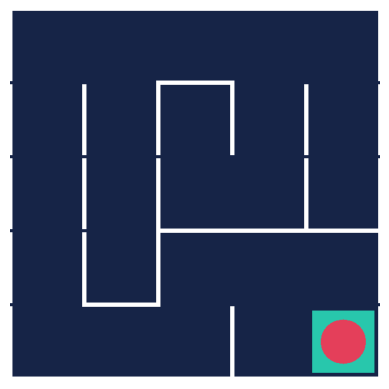

In [133]:
# Look the agent behavior with images
state, _ = env.reset()
done = False

# Crear figura inicial
fig, ax = plt.subplots()
img = ax.imshow(env.render(mode="rgb_array"))
ax.axis("off")

while not done:
    # Obtener probabilidades desde la policy
    action_probabilities = random_policy(state)

    # ⚠️ IMPORTANTE: action debe ser int, no array
    action = np.random.choice(4, p=action_probabilities)

    # Step con Gymnasium
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Actualizar imagen
    img.set_data(env.render(mode="rgb_array"))
    display.display(fig)
    display.clear_output(wait=True)

    state = next_state

env.close()